<a href="https://colab.research.google.com/github/ever-oli/MLby22/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading and cleaning dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

dataset.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/7043 [00:00<?, ? examples/s]

Data ready. Shape: (7032, 20)
Encoding categorical variables...

Before SMOTE - Training Churn Counts: 
Churn
0    4130
1    1495
Name: count, dtype: int64
After SMOTE - Training Churn Counts: 
Churn
0    4130
1    4130
Name: count, dtype: int64

Training LightGBM Classifier...
[LightGBM] [Info] Number of positive: 4130, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133704 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 664
[LightGBM] [Info] Number of data points in the train set: 8260, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Stayed (0)       0.86      0.82      0.84      1033
 Churned (1)       0.56      0.64      0.60       374

    accuracy                           0.77      1407
   macro avg       0.71      0.73      0.72      1407
weighted avg       0.78      0.77      0.78      1407



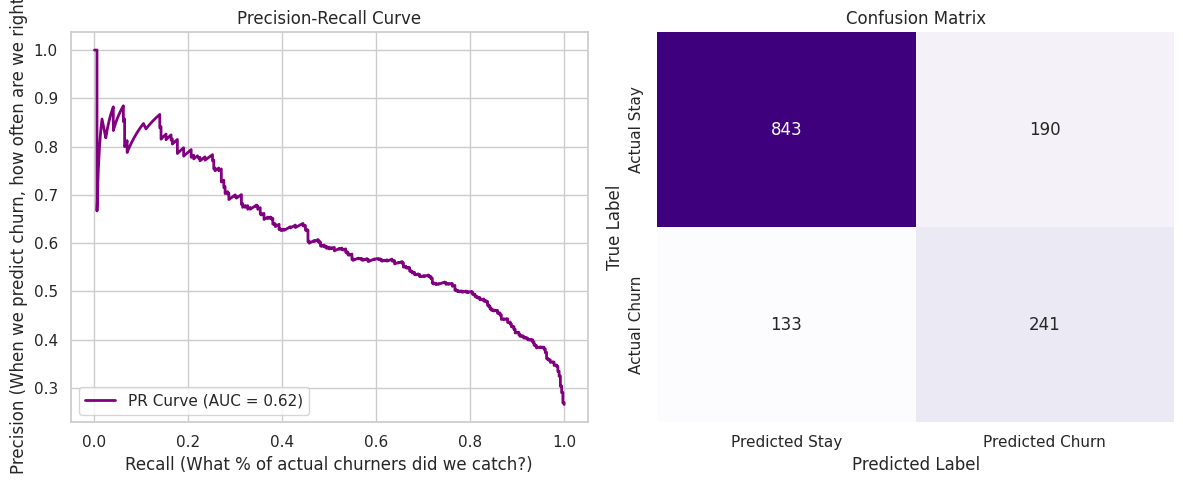


Analysis Complete.


In [1]:

# CHURN PREDICTION: CLASS IMBALANCE (SMOTE) & LIGHTGBM

# Run this cell to install required libraries:
# !pip install datasets imbalanced-learn lightgbm scikit-learn pandas matplotlib seaborn -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE
import lightgbm as lgb

# Set visualization style
sns.set_theme(style="whitegrid")


# 1. Data Ingestion & Cleaning (From EDA phase)

print("Loading and cleaning dataset...")
dataset = load_dataset("scikit-learn/churn-prediction", split="train")
df = dataset.to_pandas()

# Clean 'TotalCharges' hidden spaces and drop NaNs
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan))
df.dropna(inplace=True)

# Drop customerID as it has no predictive power
df.drop('customerID', axis=1, inplace=True)

print(f"Data ready. Shape: {df.shape}")


# 2. Feature Engineering & Encoding

print("Encoding categorical variables...")
# Separate target and features
X = df.drop('Churn', axis=1)
y = df['Churn'].map({'No': 0, 'Yes': 1}) # Convert target to binary

# One-Hot Encode categorical features
X = pd.get_dummies(X, drop_first=True)


# 3. Train/Test Split & SMOTE

# Split FIRST to prevent data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nBefore SMOTE - Training Churn Counts: \n{y_train.value_counts()}")

# Apply SMOTE only to the training set
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"After SMOTE - Training Churn Counts: \n{y_train_smote.value_counts()}\n")

# Scale features (LightGBM is tree-based and doesn't strictly require scaling,
# but it's best practice when combining with distance-based algorithms like SMOTE)
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)


# 4. Model Training (LightGBM)

print("Training LightGBM Classifier...")
# LightGBM is highly efficient and handles large datasets with ease
lgb_model = lgb.LGBMClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)

lgb_model.fit(X_train_smote, y_train_smote)


# 5. Model Evaluation (Business Metrics)

print("\nGenerating predictions and evaluating...")
y_pred = lgb_model.predict(X_test)
y_prob = lgb_model.predict_proba(X_test)[:, 1]

print("=" * 50)
print("CLASSIFICATION REPORT")
print("=" * 50)
# This report shows Precision, Recall, and F1-Score
print(classification_report(y_test, y_pred, target_names=['Stayed (0)', 'Churned (1)']))


# 6. Precision-Recall Curve Visualization

# For imbalanced datasets, PR-Curve is much more informative than ROC-AUC
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(12, 5))

# Plot 1: Precision-Recall Curve
plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='purple', lw=2, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall (What % of actual churners did we catch?)')
plt.ylabel('Precision (When we predict churn, how often are we right?)')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', cbar=False,
            xticklabels=['Predicted Stay', 'Predicted Churn'],
            yticklabels=['Actual Stay', 'Actual Churn'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

print("\nAnalysis Complete.")